In [115]:
import Pkg
Pkg.add("Convex")
Pkg.add("SCS")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [168]:
using Convex
include("./dbf_freeform.jl")
include("../sensor.jl")
order = 3;      # Order of Differential Beamformer
freq = 50;    # Frequency of Interest (in Hz)
c0 = 1500;       # Speed of Medium (m/s)
az = 30;        # Angle (in degrees)

ψ_mat = create_ψ_matrix(sensors_underwater, order, freq, c0);
γ = steering_matrix(az, order);
v = ones(Rational, 2*order+1); # Weights associated with DBF
v .//= size(v,1);
h = ComplexVariable(length(sensors_underwater), 1)
# create_ψ_matrix()

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


Variable
size: (40, 1)
sign: complex
vexity: affine
id: 181…996

In [169]:
polar_sensor = sensors_in_polar(sensors_underwater)
d_vec(f, θ, polar, c0=1500) = exp(1im * 2 * π * f * polar[1] / c0 * cos(θ - polar[2]))
d = d_vec.(freq, az, polar_sensor, c0)

40-element Vector{ComplexF64}:
 0.9998695403206286 + 0.016152471607001166im
   0.99947819532197 + 0.032300728721468525im
 0.9988260671135106 + 0.048440557950510936im
 0.9979133258481242 + 0.06456774810023577im
 0.9967402096776765 + 0.08067809127453081im
 0.9884281766156378 + 0.15168961623092578im
 0.9989721626083314 - 0.04532789796177837im
  0.988084775571357 - 0.1539106113434067im
 0.9956409008515075 - 0.09326948349593604im
  0.982597763408815 - 0.18574615835595237im
                    ⋮
 0.9546493549317819 + 0.2977324455418534im
 0.9946602294730141 + 0.10320381729708865im
 0.9786936955363762 + 0.20532571762288088im
 0.9522520294773503 + 0.30531307269140573im
 0.9156993319258852 + 0.40186407342593783im
 0.8692846611831991 + 0.4943118224679749im
 0.9366588470207429 + 0.35024306459624943im
 0.9471962382450095 + 0.3206544655146768im
 0.9715508382832093 + 0.23683109726383764im

In [170]:
function find_h_opt(ψ_mat, γ, d, v, wng_pow = 10 ^ (-0/10), sensors=sensors_underwater)
    h = ComplexVariable(length(sensors), 1)
    objective = norm(ψ_mat * h - γ' * v, 2)
    constraints = [1 ./ wng_pow >= norm(h,2), d' * h == 1]
    problem = minimize(objective, constraints)

    solve!(problem, SCS.Optimizer; silent_solver = true);
    h_opt = evaluate(h);
    return h_opt
end

find_h_opt (generic function with 4 methods)

In [171]:
using SCS
wng_pow = 10 ^ (4/10);
objective = norm(ψ_mat * h - γ' * v, 2)
constraints = [1 ./ wng_pow >= norm(h,2), d' * h == 1]
problem = minimize(objective, constraints)

solve!(problem, SCS.Optimizer)

------------------------------------------------------------------
	       SCS v3.2.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 83, constraints m: 100
cones: 	  z: primal zero / dual free vars: 3
	  l: linear vars: 1
	  q: soc vars: 96, qsize: 2
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 1225, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 2.41e+01  1.00e+00  2.42e+01 -1.20e+01  1.00e-01  4.41e-04 
   125| 2.26e-06  1.03e-06  7.36e-07  6.16e-01  7.36e-01  1.03e-03 
-------

In [172]:
h_opt = evaluate(h);
con1 = (1 ./ norm(h_opt,2) >= wng_pow);
con2 = (d' * h_opt == 1.0);
err_con2 = abs(d' * h_opt - 1);
println("Constraint 1: $con1")
println("Constraint 2: $con2 w/ error: $err_con2")

Constraint 1: false
Constraint 2: false w/ error: 7.431749421270549e-9


In [173]:
function check_constraints(h_opt, wng_pow, d)
    con1 = (1 ./ norm(h_opt,2) >= wng_pow);
    con2 = (d' * h_opt == 1.0);
    err_con2 = abs(d' * h_opt - 1);
    println("Constraint 1: $con1")
    println("Constraint 2: $con2 w/ error: $err_con2")
end

check_constraints (generic function with 1 method)

In [174]:
h_opt

40-element Vector{ComplexF64}:
  0.015720804183299023 + 0.013198289508400891im
  0.024256460797143203 + 0.026474536789920247im
     0.038423993275005 + 0.039899053364818575im
  0.058112355960007286 + 0.053553250225020985im
   0.08316761818197502 + 0.06751628870588086im
   0.04247566904522589 + 0.06559478256147949im
   0.03997816896391853 + 0.021939483806361997im
  0.019631206692513583 - 0.007152230814375726im
  0.010370243943058497 - 0.015007310454046107im
 0.0028774753267314626 - 0.029712567123977365im
                       ⋮
 -0.013076438244315623 + 0.04697762864190721im
   0.01062888949446889 + 0.023095288843487462im
 0.0038976146407195154 + 0.04556641364141384im
 -0.007218467949552832 + 0.06674127253964147im
  -0.02251159246389172 + 0.0859330995586052im
  -0.04182368251394948 + 0.1025793802034322im
  -0.02111703677169697 + 0.06580273389972079im
 0.0019933082052746146 + 0.08122089366151765im
  0.023720361747109186 + 0.07455700626416359im

In [175]:
az_list = -180:180
h_filters = Dict();
for az in az_list
    γ = steering_matrix(az, order);
    d = d_vec.(freq, deg2rad(az), polar_sensor, c0);
    h_filters[az] = find_h_opt(ψ_mat, γ, d, v, 1, sensors_underwater);
    # println("For Azimuth Angle: $(az)°")
    # check_constraints(h_filters[az], 1, d)
end

In [176]:

#=
Step 0: Open recording or generate signal
=#

# To Generate Signal:
include("../signal_generator/tone.jl")

freq = 50;          # Frequency of Tone (in Hz)
amp = 1;            # Amplitude of Tone
duration = 10;       # Duration of Tone (in seconds)
sample_rate = 32000.0;
tone_sig, n = tone(duration, amp, freq, sample_rate);

In [177]:
include("../signal_generator/generate_sig.jl")
az_gt = -90;
NFFT = 2^11;
noverlap = Int(NFFT * (3 // 4));
new_sig, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors_underwater,
                         NFFT, noverlap, hanning, az_gt, c0);

Start Simulating Signal
Signal has size: (320000, 1)


  1.481618 seconds (404.95 k allocations: 1.463 GiB, 16.82% gc time, 4.93% compilation time)
Now Generated Signal has size: (320000, 40)


In [178]:
using Random
using DSP: db2amp, pow2db
rng = Random.seed!(1234);
noise_pow = -12; # in dB
noise = rand(rng, size(new_sig,1), size(new_sig,2));
noisy_sig = new_sig + db2amp(noise_pow) .* noise;

In [179]:
function filter_freq_per_ch(new_sig)
    new_S = []
    for sig in eachcol(new_sig)
        S_interest = choose_freq(sig, freq, sample_rate);
        push!(new_S, S_interest);
    end
    # test_sig = Matrix{}(undef, size(new_sig, 2)) 
    new_S = mapreduce(permutedims, vcat, new_S);
    return new_S
end

new_S = filter_freq_per_ch(new_sig);
using Statistics
n_snapshots = 64;
Rx = cov(new_S[:,1:n_snapshots], dims=2);

In [180]:
P = [];
for az in az_list
    h_opt = h_filters[az];
    P_val = h_opt' * Rx * h_opt;
    push!(P, abs(P_val));
end

In [181]:
include("./cbf.jl")
P_db, az_max = predict_az(P, az_list)

([-17.141929653594467, -16.55036749335222, -15.986544297539965, -15.447897739423084, -14.932226156204699, -14.437624563150969, -13.962434121300035, -13.505201831785683, -13.064648091930046, -12.639640357672683  …  -24.484050843135947, -23.396032418938702, -22.40316212065656, -21.48970574561747, -20.643450528223468, -19.854773194451482, -19.115980476810982, -18.420838951462592, -17.764235659105807, -17.14192965359298], -90)

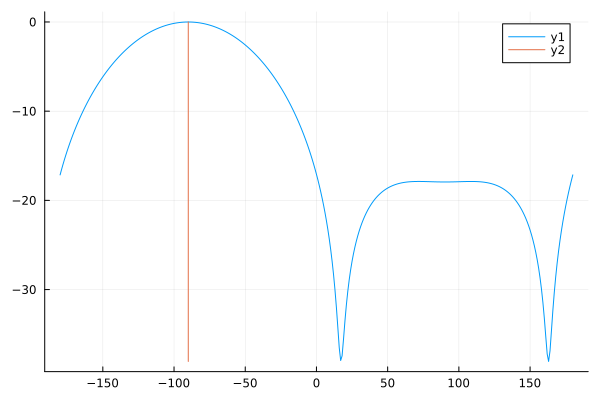

In [182]:
using Plots
ymin = minimum(P_db);
plot1 = plot(az_list, P_db)
plot!([az_max; az_max], [ymin; 0])
display(plot1)

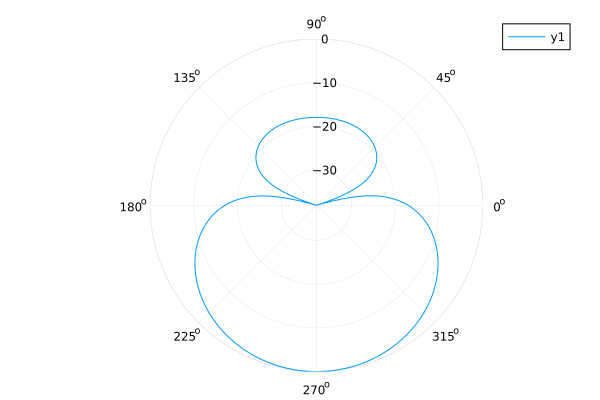

In [183]:
plot(deg2rad.(az_list), P_db, proj=:polar)
ylims!((ymin, 0))